<img src='https://static.wixstatic.com/media/e9b721_888e9daa53994dfd9d2214ad1a823fcc~mv2.png/v1/fit/w_1000%2Ch_205%2Cal_c/file.png'/>

In [2]:
from sklearn.datasets import make_circles

In [3]:
import pandas as pd

In [4]:
import torch

In [5]:
from torch import nn

In [6]:
import matplotlib.pyplot as plt

# Make Classification Data

In [8]:
n_samples = 1000
X,y=make_circles(n_samples, noise=0.03, random_state=42)

In [9]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [10]:
circles = pd.DataFrame({'X1':X[:,0],
                       'X2':X[:,1],
                       'labels':y})
circles.head()

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [11]:
type(circles)

pandas.core.frame.DataFrame

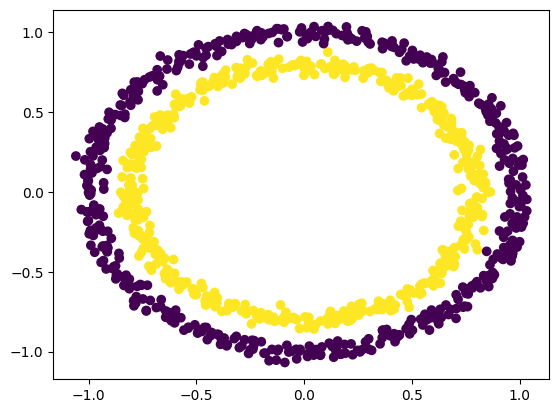

In [9]:
plt.scatter(x=X[:,0], y=X[:,1],c=y)

# Check input and output shapes

In [10]:
X[0]

array([0.75424625, 0.23148074])

In [11]:
y[0]

1

In [12]:
X.shape, y.shape

((1000, 2), (1000,))

In [13]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [14]:
# 1.2 Turn data into tensors and create train-test split

In [15]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [16]:
type(X), X.dtype

(torch.Tensor, torch.float32)

In [17]:
type(y), y.dtype

(torch.Tensor, torch.float32)

In [18]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
len(X_train), len(y_train),  len(X_test), len(y_test)

(800, 800, 200, 200)

# Model Building

In [22]:
# Setup device agonistic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [23]:
# Construct the model
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer 1 -> layer 2 -> output

model = CircleModel().to(device)
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [24]:
device

'cuda'

In [25]:
next(model.parameters()).device

device(type='cuda', index=0)

In [26]:
# simpler method (for simple datasets only)
model_simple = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_simple

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [27]:
# define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [28]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

Before the training loop steps, let's see what comes out of our model during the forward pass (the forward pass is defined by the forward() method).

In [33]:
y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[-0.1300],
        [-0.0989],
        [-0.2562],
        [-0.0941],
        [-0.3267]], device='cuda:0', grad_fn=<SliceBackward0>)

- They're the output of our `forward()` method.
- It implements two layers of nn.Linear() which internally calls `Linear Equation`
- The raw outputs (unmodified outputs) is known as **`logits`**

In [35]:
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.4675],
        [0.4753],
        [0.4363],
        [0.4765],
        [0.4190]], device='cuda:0', grad_fn=<SigmoidBackward0>)

- These are now **prediction probabilities**, which means, how sure the model is the specific data-point belongs to a particular class
- In case of **binary class classification**, ideal output is **0 or 1**
- More specificially:
    - If **y_pred_probs** >= 0.5, **y=1** (class 1)
    - If **y_pred_probs** < 0.5, **y=0** (class 0) 0)

In [37]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_prob)

# In full
y_pred_labels = torch.round(torch.sigmoid(model(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

- Prediction probabilities were in decimal format (0.6538). It needed to be in the format of y_test (either 0 or 1).
- Thus sigmoid activation function is used.
- Now the models prediction is in 0 or 1 format, it is possible to compare it with actual true value to evaluate its accuracy

- **Note: The use of the sigmoid activation function is often only for binary classification logits. For multi-class classification, we'll be looking at using the softmax activation function (this will come later on).**

- **And the use of the sigmoid activation function is not required when passing our model's raw outputs to the nn.BCEWithLogitsLoss (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.**

Training Loop Steps:
1. Create a Forward Pass
2. Calculate the loss
3. Optimize zero grad
4. Loss Backward (backpropagation)
5. Optimizer step

In [38]:
# Create Train and Test loop
torch.manual_seed(42)
torch.cuda.manual_seed(42) # Only if code is running on GPU

epochs = 100
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward Pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calc. The Loss & Acc
    loss = loss_fn(y_logits, y_train) # Using nn.BCEWithLogitsLoss works with raw logits
    acc = accuracy(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ## Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward Pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_true=y_test, y_pred=test_pred)
    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69975, Accuracy: 50.00% | Test loss: 0.70184, Test acc: 50.00%
Epoch: 10 | Loss: 0.69560, Accuracy: 50.00% | Test loss: 0.69818, Test acc: 50.00%
Epoch: 20 | Loss: 0.69406, Accuracy: 45.62% | Test loss: 0.69679, Test acc: 47.00%
Epoch: 30 | Loss: 0.69347, Accuracy: 48.38% | Test loss: 0.69623, Test acc: 45.50%
Epoch: 40 | Loss: 0.69325, Accuracy: 49.50% | Test loss: 0.69596, Test acc: 45.50%
Epoch: 50 | Loss: 0.69315, Accuracy: 49.88% | Test loss: 0.69581, Test acc: 47.00%
Epoch: 60 | Loss: 0.69311, Accuracy: 50.75% | Test loss: 0.69569, Test acc: 45.50%
Epoch: 70 | Loss: 0.69308, Accuracy: 50.62% | Test loss: 0.69560, Test acc: 47.00%
Epoch: 80 | Loss: 0.69307, Accuracy: 50.75% | Test loss: 0.69552, Test acc: 47.00%
Epoch: 90 | Loss: 0.69306, Accuracy: 50.62% | Test loss: 0.69545, Test acc: 46.00%


Since the model's accuracy is 50%, it is as good as randomly guessing.

In [39]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

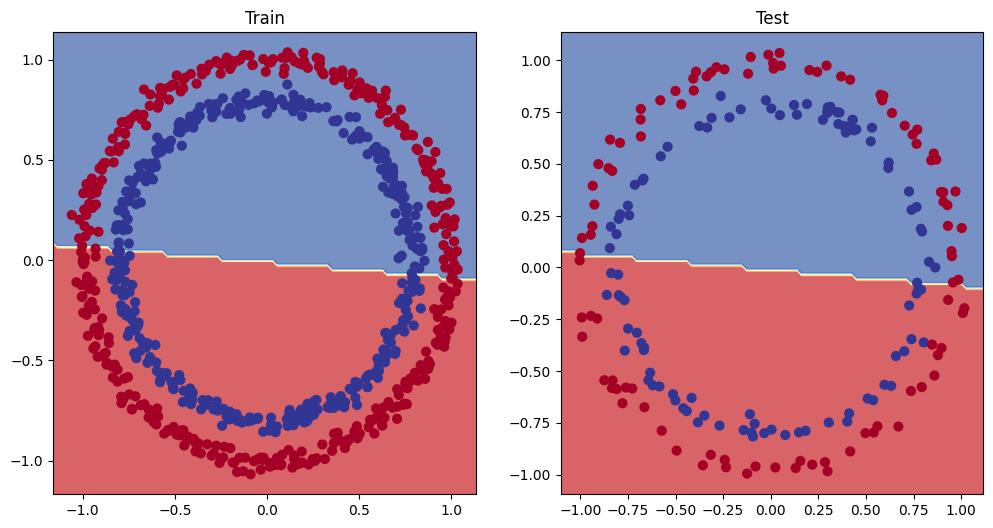

In [41]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

- This indicates that the decision boundary is a straight line, and data is circular.
- Thus it is impossible to increase its efficiency with more training.

# <center>Improving a model (from a model perspective)</center>

<table border="1">
    <tr>
        <th>Model Improvement Technique</th>
        <th>What Does It Do?</th>
    </tr>
    <tr>
        <td>Add more layers</td>
        <td>Each layer potentially increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network deeper.</td>
    </tr>
    <tr>
        <td>Add more hidden units</td>
        <td>Similar to the above, more hidden units per layer means a potential increase in learning capabilities of the model, more hidden units is often referred to as making your neural network wider.</td>
    </tr>
    <tr>
        <td>Fitting for longer (more epochs)</td>
        <td>Your model might learn more if it had more opportunities to look at the data.</td>
    </tr>
    <tr>
        <td>Changing the activation functions</td>
        <td>Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint).</td>
    </tr>
    <tr>
        <td>Change the learning rate</td>
        <td>Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough.</td>
    </tr>
    <tr>
        <td>Change the loss function</td>
        <td>Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem.</td>
    </tr>
    <tr>
        <td>Use transfer learning</td>
        <td>Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. We cover transfer learning in notebook 06.</td>
    </tr>
</table>

#### **Note:** because you can adjust all of these by hand, they're referred to as **hyperparameters**.#### It is important to know that implementing all changes in one go is **NOT** recommended because we will not know what offered improvement and what caused degradation (Experiment Tracking)



Improvements to be applied:
- Adding More hidden Units (5 -> 10)
- Increase The number of layers (2 -> 3)
- Increase The number of epochs (100 -> 1000)

In [44]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self,x):
        return self.layer3(self.layer2(self.layer1(x)))

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [45]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [46]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000
for epoch in range(epochs):
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


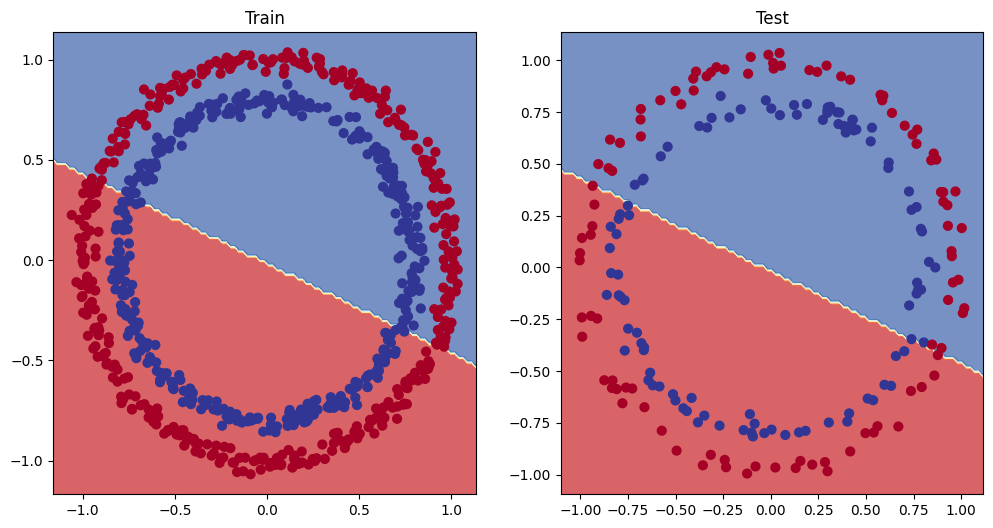

In [47]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

- This did not work either.
- This is because model does not fit with linear line because the dataset is non linear.
- Thus we need non-linear model that fits with the data

In [62]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [63]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [66]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 2000
for epoch in range(epochs):
    model_2.train()
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_2(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy(y_true=y_test,
                             y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.04170, Accuracy: 99.88% | Test loss: 0.06576, Test acc: 100.00%
Epoch: 100 | Loss: 0.03623, Accuracy: 99.88% | Test loss: 0.05973, Test acc: 100.00%
Epoch: 200 | Loss: 0.03201, Accuracy: 99.88% | Test loss: 0.05455, Test acc: 100.00%
Epoch: 300 | Loss: 0.02869, Accuracy: 99.88% | Test loss: 0.05018, Test acc: 100.00%
Epoch: 400 | Loss: 0.02602, Accuracy: 99.88% | Test loss: 0.04659, Test acc: 100.00%
Epoch: 500 | Loss: 0.02381, Accuracy: 99.88% | Test loss: 0.04360, Test acc: 100.00%
Epoch: 600 | Loss: 0.02194, Accuracy: 99.88% | Test loss: 0.04089, Test acc: 100.00%
Epoch: 700 | Loss: 0.02034, Accuracy: 99.88% | Test loss: 0.03862, Test acc: 100.00%
Epoch: 800 | Loss: 0.01896, Accuracy: 99.88% | Test loss: 0.03679, Test acc: 100.00%
Epoch: 900 | Loss: 0.01776, Accuracy: 99.88% | Test loss: 0.03510, Test acc: 100.00%
Epoch: 1000 | Loss: 0.01671, Accuracy: 99.88% | Test loss: 0.03361, Test acc: 100.00%
Epoch: 1100 | Loss: 0.01577, Accuracy: 99.88% | Test loss: 0.03230

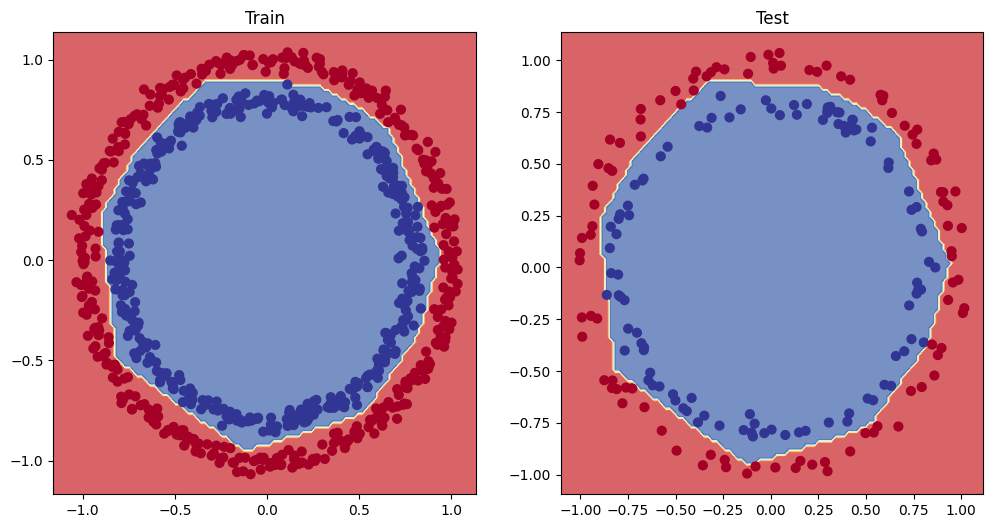

In [68]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)